### This notebook contains a series of experiments to see which one performs the best.

* Naive Bayes Baseline Model
* Feed forward NN
* LSTM
* GRU
* Bidirectional LSTM
* 1D CNN
* tf Hub Feature Extraction (in NLP3 notebook)
* tf Hub Pretrained Feature Extraction (10% data) (in NLP3 notebook)

In [ ]:
!wget "https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip"

!unzip "/content/nlp_getting_started.zip"

import pandas as pd

train_df = pd.read_csv("/content/train.csv")

test_df = pd.read_csv("/content/test.csv")

train_df_shuffled = train_df.sample(frac = 1,random_state= 42)

from sklearn.model_selection import train_test_split

train_sentences,val_sentences,train_labels,val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                         train_df_shuffled["target"].to_numpy(),
                                                                         test_size  = 0.1,
                                                                         random_state = 42)

--2021-06-06 18:01:02--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.15.80, 172.217.9.208, 172.217.12.240, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.15.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.005s  

2021-06-06 18:01:02 (110 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]

Archive:  /content/nlp_getting_started.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


### MODEL-0 BASELINE MODEL

In [ ]:
# This model uses Multinomial Naive Bayes from sklearn

# We also use Tfidf vectorizer in this.

# Pipeline is used in sklearn to make models (similar to tensroflow)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.naive_bayes import MultinomialNB

from sklearn.pipeline import Pipeline

In [ ]:
model0 = Pipeline([
                   ("tfidf",TfidfVectorizer()),
                   ("clf",MultinomialNB())   
])

In [ ]:
# Fitting the model

model0.fit(train_sentences,train_labels)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [ ]:
# Getting the baseline score / evaluation

baselinescore = model0.score(val_sentences,val_labels)

print(f"The baseline accuracy is {baselinescore*100:.2f}.")

The baseline accuracy is 79.27.


In [ ]:
# Making predicitions

baseline_preds = model0.predict(val_sentences)

baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

### Making a function to evaluate our model using various metrics like accuracy,precision,recall and f1 score

In [ ]:
from sklearn.metrics import accuracy_score,precision_recall_fscore_support

In [ ]:
def calculate_results(y_true,y_pred):

  model_accuracy = accuracy_score(y_true,y_pred)*100

  model_precision,model_recall,model_f1,_ = precision_recall_fscore_support(y_true,y_pred,average = "weighted")

  model_results = {"accuracy":model_accuracy,
                   "precision":model_precision,
                   "recall":model_recall,
                   "f1_score":model_f1}

  return model_results


In [ ]:
# Evaluating Model-0

baseline_results = calculate_results(val_labels,baseline_preds)

baseline_results

{'accuracy': 79.26509186351706,
 'f1_score': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

### Model-1 (A simple Dense Model)

In [ ]:
import tensorflow as tf

from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [ ]:
max_vocab_length = 10000

# Find average length to set it as the max length 

max_length = round(sum(len(i.split()) for i in train_sentences)/len(train_sentences))


# Making the text vectorizer

text_vectorizer = TextVectorization(max_tokens = max_vocab_length,
                                    output_mode = "int",
                                    output_sequence_length = max_length)

# Fit/Adapt the vectorizer

text_vectorizer.adapt(train_sentences)

# Embedding
embedding = tf.keras.layers.Embedding(input_dim = max_vocab_length,
                                      output_dim = 128,
                                      input_length = max_length)

In [ ]:
# Creating a functional model

inputs = tf.keras.layers.Input(shape = (1,),dtype=tf.string)

x = text_vectorizer(inputs)

x = embedding(x)

x = tf.keras.layers.GlobalAveragePooling1D()(x) # If we dont add this layer later we will get prob for each token instead of just one prob which is needed

outputs = tf.keras.layers.Dense(1,activation = "sigmoid")(x)

model1 = tf.keras.Model(inputs,outputs,name = "Model1_Dense")

In [ ]:
model1.summary()

Model: "Model1_Dense"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 1,280,129
Trainable params: 1,280,129
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Compiling the model

model1.compile(loss = "binary_crossentropy",
               optimizer = "Adam",
               metrics = ["accuracy"])

In [ ]:
# Fitting the model

model1_history = model1.fit(x = train_sentences,
                            y = train_labels,
                            epochs =5,
                            validation_data = (val_sentences,val_labels))

Epoch 1/5
215/215 [==============================] - 6s 14ms/step - loss: 0.6116 - accuracy: 0.6932 - val_loss: 0.5374 - val_accuracy: 0.7533
Epoch 2/5
215/215 [==============================] - 3s 13ms/step - loss: 0.4424 - accuracy: 0.8181 - val_loss: 0.4684 - val_accuracy: 0.7861
Epoch 3/5
215/215 [==============================] - 3s 13ms/step - loss: 0.3472 - accuracy: 0.8600 - val_loss: 0.4601 - val_accuracy: 0.7913
Epoch 4/5
215/215 [==============================] - 3s 14ms/step - loss: 0.2844 - accuracy: 0.8923 - val_loss: 0.4636 - val_accuracy: 0.7953
Epoch 5/5
215/215 [==============================] - 3s 14ms/step - loss: 0.2378 - accuracy: 0.9127 - val_loss: 0.4872 - val_accuracy: 0.7822


In [ ]:
model1_preds = model1.predict(val_sentences)

model1_preds

array([[2.90409535e-01],
       [7.51319826e-01],
       [9.97954965e-01],
       [1.22851297e-01],
       [1.18103497e-01],
       [9.43312347e-01],
       [9.18484807e-01],
       [9.92962062e-01],
       [9.58067238e-01],
       [3.17279756e-01],
       [8.71264040e-02],
       [7.02812493e-01],
       [4.05485108e-02],
       [1.37334451e-01],
       [4.29916149e-03],
       [1.05443276e-01],
       [2.42434330e-02],
       [7.13663623e-02],
       [2.15437561e-01],
       [5.06518304e-01],
       [9.02376473e-01],
       [3.70742753e-02],
       [3.52833003e-01],
       [6.74038231e-02],
       [9.50988829e-01],
       [9.99036908e-01],
       [3.93978581e-02],
       [5.66081777e-02],
       [2.19472665e-02],
       [1.67825565e-01],
       [5.43134749e-01],
       [2.86208689e-01],
       [4.37042415e-01],
       [1.59930751e-01],
       [4.09922421e-01],
       [4.80832160e-02],
       [9.94907320e-01],
       [1.67811558e-01],
       [2.75453590e-02],
       [9.98313546e-01],


In [ ]:
model1_preds.shape

(762, 1)

In [ ]:
model1_preds = tf.squeeze(tf.round(model1_preds))

model1_preds

<tf.Tensor: shape=(762,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0.,
       0., 1., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1.,
       0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 1., 1., 1., 0.,
       1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0.,
       1., 1., 1., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0.,
       0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0

In [ ]:
model1_results = calculate_results(val_labels,model1_preds)

model1_results

{'accuracy': 78.21522309711287,
 'f1_score': 0.7786244698114966,
 'precision': 0.7881971444440814,
 'recall': 0.7821522309711286}

In [ ]:
baseline_results

{'accuracy': 79.26509186351706,
 'f1_score': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

In [ ]:
# The results are more of less the same.

### Visualizing the embedding

In [ ]:
# Getting the words in Vocabulary

words_in_vocab = text_vectorizer.get_vocabulary()

model1.summary()

Model: "Model1_Dense"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 1,280,129
Trainable params: 1,280,129
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Getting the embedding layer weights

embed_weights = model1.get_layer("embedding").get_weights()[0]

embed_weights

array([[ 0.00371731, -0.05651404,  0.02444945, ...,  0.02071255,
         0.03655092, -0.02490743],
       [-0.0207548 , -0.03100088, -0.00689558, ...,  0.02835663,
        -0.03634699,  0.00735753],
       [-0.0195266 , -0.05560093, -0.0264067 , ..., -0.00883747,
         0.01397427,  0.03053216],
       ...,
       [-0.014228  ,  0.00125999,  0.01816011, ..., -0.00180722,
        -0.00560895,  0.00617963],
       [-0.09054848, -0.02030469,  0.02457651, ...,  0.06241975,
        -0.00572699, -0.03030325],
       [-0.04671511, -0.09291813,  0.11472882, ...,  0.03933244,
         0.04288903, -0.04839631]], dtype=float32)

In [ ]:
embed_weights.shape

(10000, 128)

##### Using the Tensorflow Projector tool for visualizing

https://projector.tensorflow.org/  - This is the link to visualize the embedding.

https://www.tensorflow.org/text/guide/word_embeddings - This link has the code to create the vecs.tsv and meta.tsv files which are needed by projector tool.

Change words in vocab and embed weights in code according to our variable names.


In [ ]:
import io

out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(words_in_vocab):
  if index == 0:
    continue  # skip 0, it's padding.
  vec = embed_weights[index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()

##### Downloading files to local machine

In [ ]:
try:
  from google.colab import files
  files.download('vectors.tsv')
  files.download('metadata.tsv')
except Exception:
  pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##### Visualize by uploading to projector tool

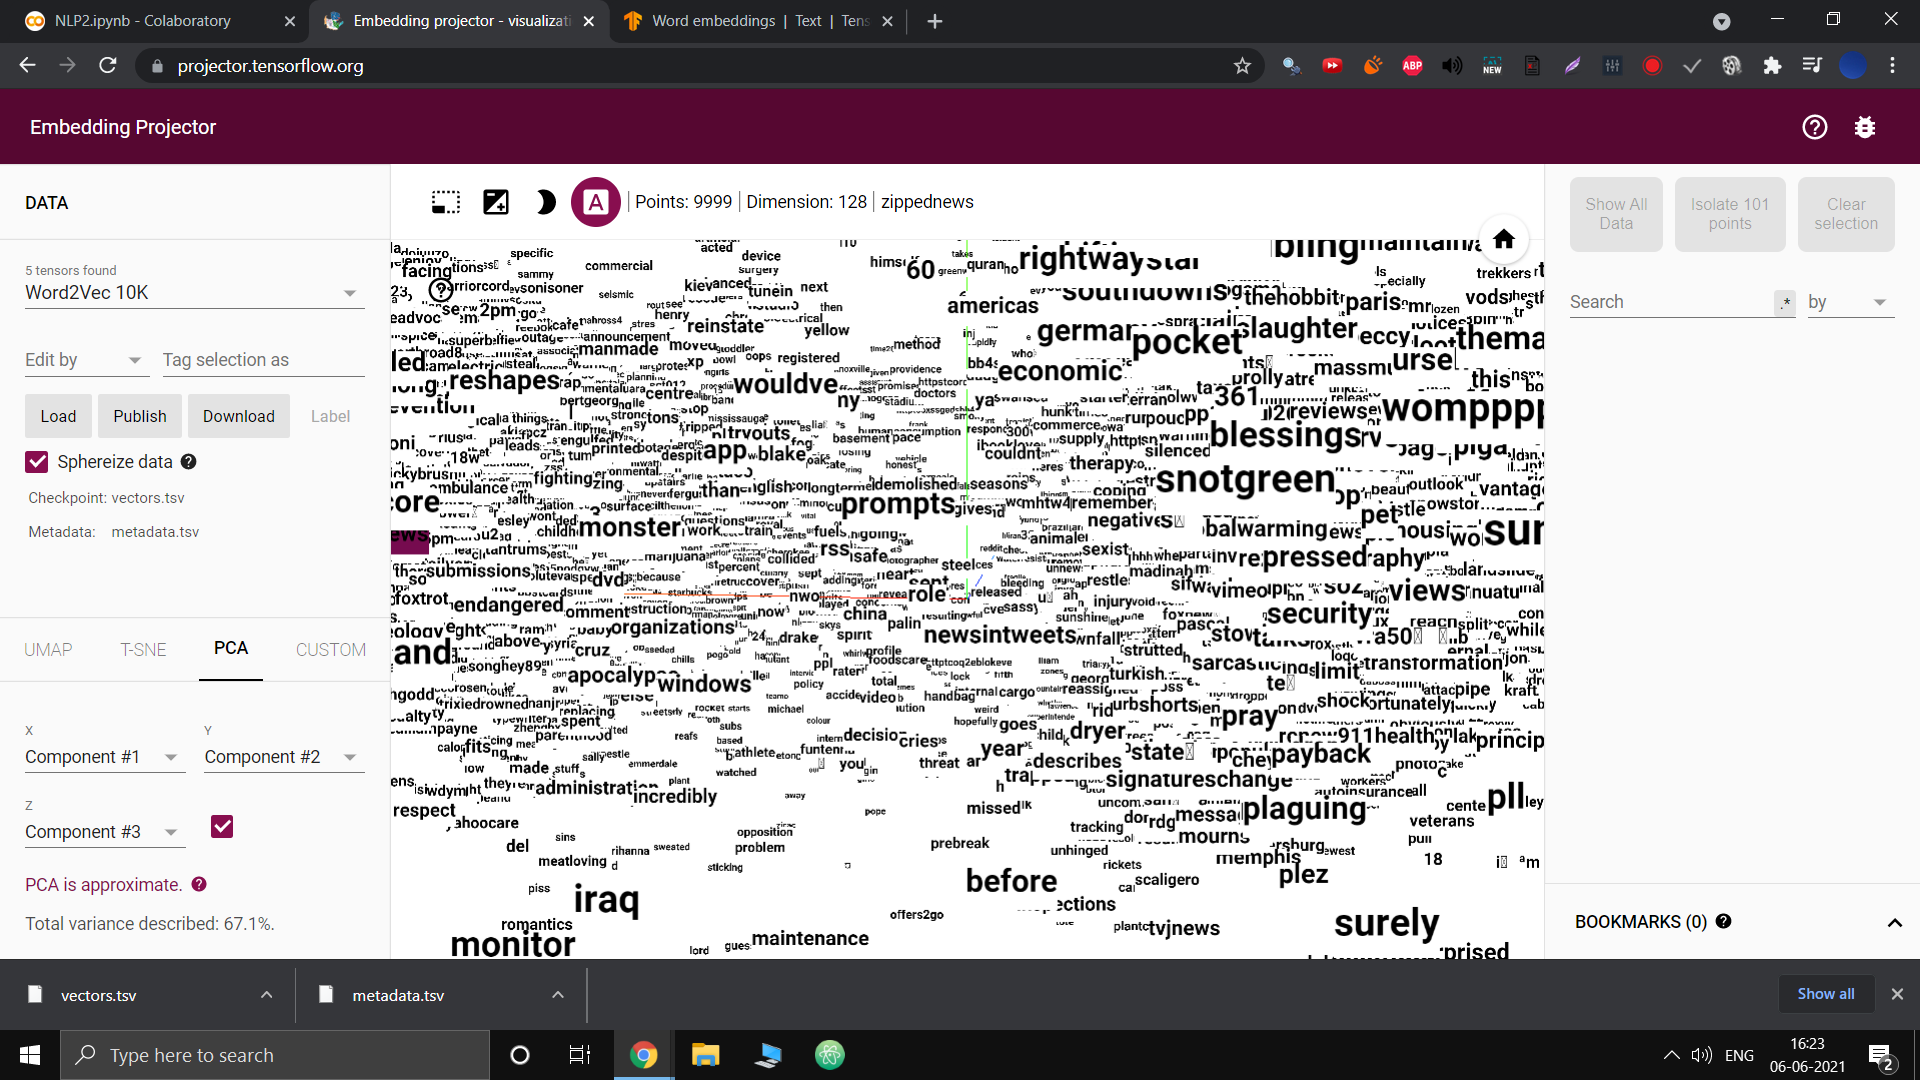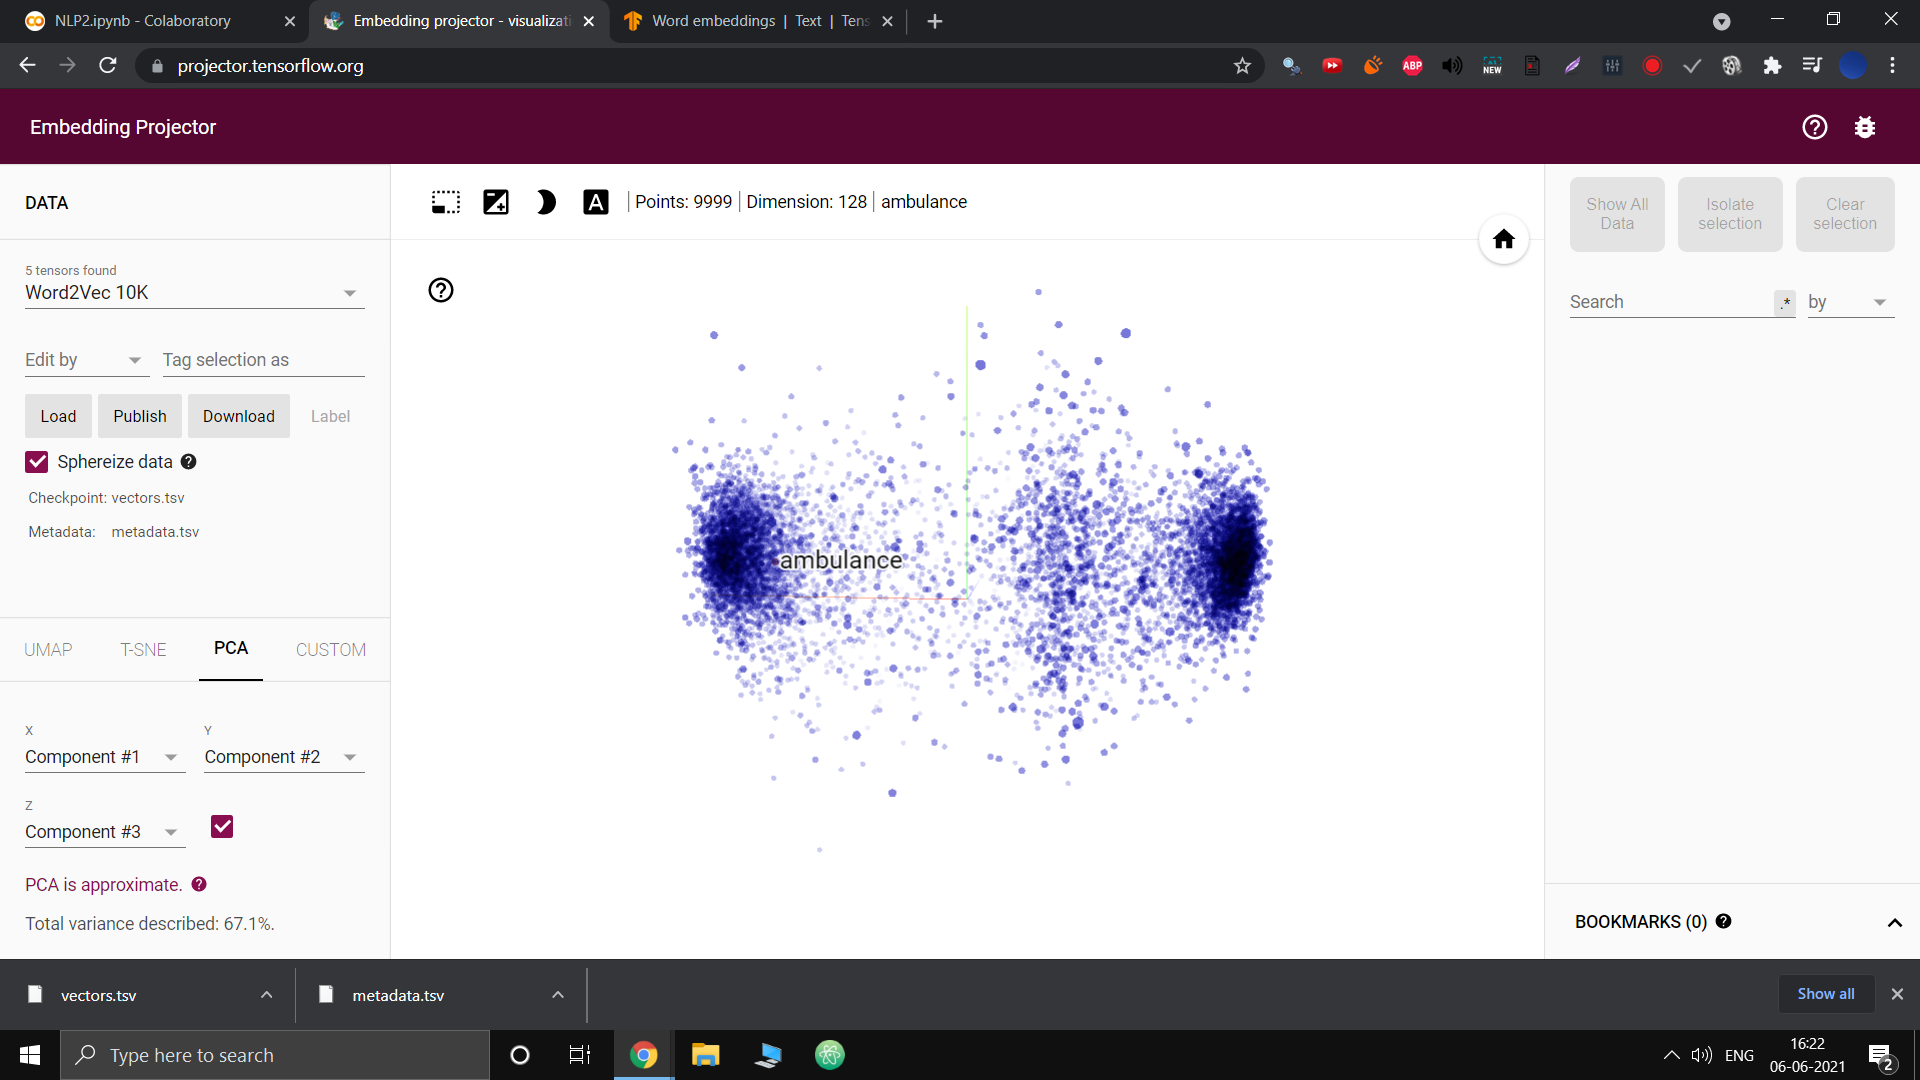

In [ ]:
# We can see that two clusters are being formed which also tells us about the two classes of disaster and not-disaster tweets we have.

### Recurrent Neural Networks

##### Helpful links 

* https://www.youtube.com/watch?v=qjrad0V0uJE&list=PLtBw6njQRU-rwp5__7C0oIVt26ZgjG9NI&index=3

* https://colah.github.io/posts/2015-08-Understanding-LSTMs/

* http://karpathy.github.io/2015/05/21/rnn-effectiveness/



##### RNN Architecture

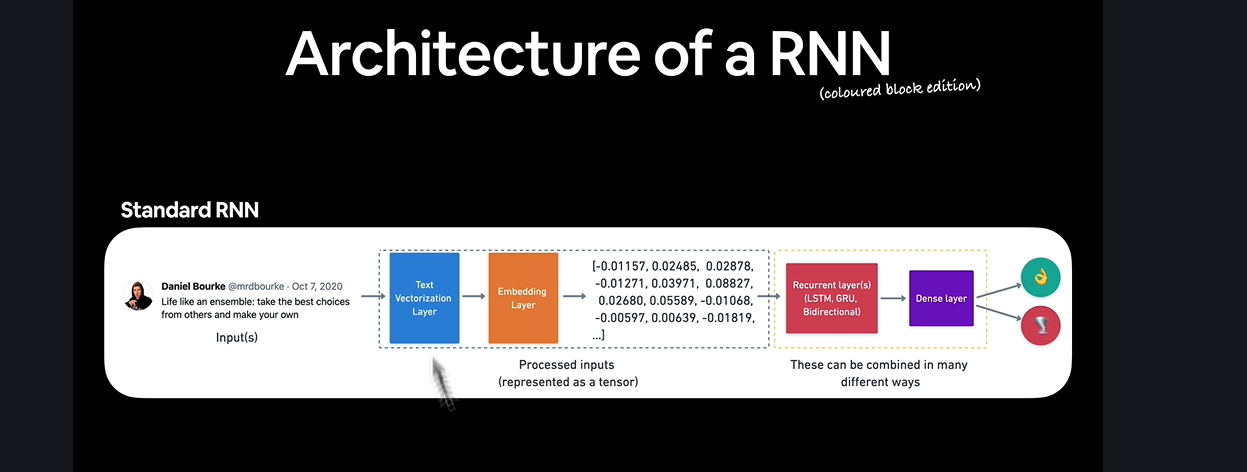


### Model-2 (LSTM)

##### Strcuture of our model

input->tokenize->embedding->layers(RNN,Dense)->Output


In [ ]:
inputs = tf.keras.layers.Input(shape = (1,),dtype=tf.string)

x = text_vectorizer(inputs)

x = embedding(x)

# If we have multiple LSTM layers stacked then we need to make the parameter return sequence = True as LSTM layer requires 3 dimensions and if the param is false it returns 2 dims giving error to next layer.
x = tf.keras.layers.LSTM(64)(x)

outputs = tf.keras.layers.Dense(1,activation="sigmoid")(x)

model2 = tf.keras.Model(inputs,outputs,name = "Model_2_LSTM")



In [ ]:
model2.summary()

Model: "Model_2_LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
lstm (LSTM)                  (None, 64)                49408     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 1,329,473
Trainable params: 1,329,473
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Compiling

model2.compile(loss = "binary_crossentropy",
               optimizer = "Adam",
               metrics = ["accuracy"])

In [ ]:
# Fitting

model2_history = model2.fit(x = train_sentences,
                            y = train_labels,
                            epochs = 5,
                            validation_data = (val_sentences,val_labels)) 

Epoch 1/5
215/215 [==============================] - 9s 17ms/step - loss: 0.2219 - accuracy: 0.9197 - val_loss: 0.5137 - val_accuracy: 0.7900
Epoch 2/5
215/215 [==============================] - 3s 15ms/step - loss: 0.1556 - accuracy: 0.9423 - val_loss: 0.5852 - val_accuracy: 0.7887
Epoch 3/5
215/215 [==============================] - 3s 15ms/step - loss: 0.1238 - accuracy: 0.9536 - val_loss: 0.7115 - val_accuracy: 0.7887
Epoch 4/5
215/215 [==============================] - 3s 15ms/step - loss: 0.1085 - accuracy: 0.9599 - val_loss: 0.6828 - val_accuracy: 0.7848
Epoch 5/5
215/215 [==============================] - 3s 15ms/step - loss: 0.0851 - accuracy: 0.9688 - val_loss: 0.9811 - val_accuracy: 0.7730


In [ ]:
model2_preds = model2.predict(val_sentences)

model2_preds

array([[5.55202104e-02],
       [7.72335887e-01],
       [9.99841809e-01],
       [2.10533645e-02],
       [7.41943426e-04],
       [9.99236107e-01],
       [9.46606457e-01],
       [9.99892354e-01],
       [9.99810278e-01],
       [5.03032207e-01],
       [8.66979593e-04],
       [9.75343645e-01],
       [4.95164888e-04],
       [9.69208360e-01],
       [1.80920251e-04],
       [2.54930044e-03],
       [1.13148207e-03],
       [8.71215365e-04],
       [1.12114009e-02],
       [9.99295592e-01],
       [9.99571025e-01],
       [3.55314638e-04],
       [9.81936753e-01],
       [1.30867865e-03],
       [9.99841809e-01],
       [9.99847412e-01],
       [2.85665225e-03],
       [9.85352788e-04],
       [5.55730367e-04],
       [1.68187737e-01],
       [9.96541798e-01],
       [1.36282053e-02],
       [3.58258449e-02],
       [6.65937969e-03],
       [8.40237975e-01],
       [7.91558400e-02],
       [9.99762356e-01],
       [2.30874553e-01],
       [4.36775535e-02],
       [9.99846220e-01],


In [ ]:
model2_preds.shape

(762, 1)

In [ ]:
model2_preds = tf.round(tf.squeeze(model2_preds))

print(model2_preds)

print()

print(model2_preds.shape)

tf.Tensor(
[0. 1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0.
 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 1. 1. 1.
 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 1. 1. 0. 1. 0. 0. 0.
 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 1. 1.
 1. 1. 1. 1. 1. 0. 0. 1. 1. 0. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 1. 1. 1. 0.
 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 1. 1. 1. 0. 1. 0. 0. 0. 1. 1. 1. 1.
 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0.
 1. 0. 1. 1. 1. 0. 1. 0. 0. 0. 1. 1. 0. 1. 1. 1. 1. 0. 0. 1. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0.
 1. 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0.
 1. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 1.
 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 1. 1. 0. 1. 0.
 1. 0. 1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 

In [ ]:
model2_results = calculate_results(val_labels,model2_preds)

model2_results

{'accuracy': 77.29658792650919,
 'f1_score': 0.77144803030122,
 'precision': 0.77365375135567,
 'recall': 0.7729658792650919}

### Model-3 (GRU - Gated Recurrent Unit)



In [ ]:
inputs = tf.keras.layers.Input(shape = (1,),dtype = tf.string)

x = text_vectorizer(inputs)

x = embedding(x)

x = tf.keras.layers.GRU(64)(x)

outputs = tf.keras.layers.Dense(1,activation="sigmoid")(x)

model3 = tf.keras.Model(inputs,outputs,name = "Model_3_GRU")

In [ ]:
model3.summary()

Model: "Model_3_GRU"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
gru_1 (GRU)                  (None, 64)                37248     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 1,317,313
Trainable params: 1,317,313
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Compiling

model3.compile(loss = "binary_crossentropy",
               optimizer = "Adam",
               metrics = ["accuracy"])

In [ ]:
# Fitting

model3_history = model3.fit(train_sentences,
                            train_labels,
                            epochs = 5,
                            validation_data = (val_sentences,val_labels))

Epoch 1/5
215/215 [==============================] - 5s 17ms/step - loss: 0.1547 - accuracy: 0.9391 - val_loss: 0.7776 - val_accuracy: 0.7677
Epoch 2/5
215/215 [==============================] - 3s 15ms/step - loss: 0.0846 - accuracy: 0.9707 - val_loss: 0.8434 - val_accuracy: 0.7690
Epoch 3/5
215/215 [==============================] - 3s 16ms/step - loss: 0.0716 - accuracy: 0.9730 - val_loss: 0.7669 - val_accuracy: 0.7795
Epoch 4/5
215/215 [==============================] - 3s 15ms/step - loss: 0.0628 - accuracy: 0.9747 - val_loss: 1.3454 - val_accuracy: 0.7677
Epoch 5/5
215/215 [==============================] - 3s 15ms/step - loss: 0.0569 - accuracy: 0.9756 - val_loss: 1.1586 - val_accuracy: 0.7756


In [ ]:
model3_preds = model3.predict(val_sentences)

model3_preds

array([[7.88619742e-04],
       [8.10297310e-01],
       [9.99850750e-01],
       [3.43923233e-02],
       [9.01252133e-05],
       [9.99666810e-01],
       [9.32878137e-01],
       [9.99953985e-01],
       [9.99894500e-01],
       [8.11718404e-01],
       [5.02534502e-04],
       [9.90579784e-01],
       [2.12208237e-04],
       [2.75874794e-01],
       [1.53943867e-04],
       [9.62019141e-04],
       [1.47346372e-03],
       [4.81737428e-04],
       [9.73416958e-03],
       [9.99820173e-01],
       [9.99929667e-01],
       [6.22033476e-05],
       [9.99600351e-01],
       [1.34051440e-03],
       [9.99885321e-01],
       [9.99911189e-01],
       [6.05191395e-04],
       [3.90912319e-04],
       [1.63902339e-04],
       [4.28374082e-01],
       [9.97268975e-01],
       [8.10871308e-04],
       [1.87959909e-01],
       [4.27919347e-03],
       [8.21261227e-01],
       [2.22339287e-01],
       [9.99800861e-01],
       [1.30988210e-01],
       [5.28198555e-02],
       [9.99921083e-01],


In [ ]:
model3_preds.shape

(762, 1)

In [ ]:
model3_preds = tf.squeeze(tf.round(model3_preds))

print(model3_preds)

print()

print(model3_preds.shape)

tf.Tensor(
[0. 1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0.
 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 1. 1. 1.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 1. 1. 0. 1. 0. 0. 0.
 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 1. 1.
 1. 1. 1. 1. 1. 0. 0. 1. 1. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0.
 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 1. 1. 1. 0. 1. 0. 0. 0. 1. 1. 0. 1.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0.
 1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1. 1. 1. 0. 0. 1. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0.
 1. 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 1.
 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 1. 1. 0. 1. 0.
 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 

In [ ]:
# Evaluating

model3_results = calculate_results(val_labels,model3_preds)

model3_results

{'accuracy': 77.55905511811024,
 'f1_score': 0.7734917819402004,
 'precision': 0.7774694686899193,
 'recall': 0.7755905511811023}

In [ ]:
# The results are still not better than the baseline model

### Model-4 (Bidirectional RNN)

In [ ]:
inputs = tf.keras.layers.Input(shape = (1,),dtype = tf.string)

x = text_vectorizer(inputs)

x = embedding(x)

x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64))(x)

outputs = tf.keras.layers.Dense(1,activation = "sigmoid")(x)

model4 = tf.keras.Model(inputs,outputs,name = "Model_4_Bidirectional")

In [ ]:
model4.summary()

Model: "Model_4_Bidirectional"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               98816     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 129       
Total params: 1,378,945
Trainable params: 1,378,945
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Compiling

model4.compile(loss = "binary_crossentropy",
               optimizer = "Adam",
               metrics = ["accuracy"])

In [ ]:
# Fitting

model4_history = model4.fit(train_sentences,
                            train_labels,
                            epochs = 5,
                            validation_data = (val_sentences,val_labels))

Epoch 1/5
215/215 [==============================] - 7s 20ms/step - loss: 0.1045 - accuracy: 0.9695 - val_loss: 0.9763 - val_accuracy: 0.7612
Epoch 2/5
215/215 [==============================] - 4s 18ms/step - loss: 0.0568 - accuracy: 0.9759 - val_loss: 1.2201 - val_accuracy: 0.7703
Epoch 3/5
215/215 [==============================] - 4s 17ms/step - loss: 0.0467 - accuracy: 0.9784 - val_loss: 1.2134 - val_accuracy: 0.7585
Epoch 4/5
215/215 [==============================] - 4s 17ms/step - loss: 0.0425 - accuracy: 0.9799 - val_loss: 1.4184 - val_accuracy: 0.7717
Epoch 5/5
215/215 [==============================] - 4s 17ms/step - loss: 0.0403 - accuracy: 0.9806 - val_loss: 1.4856 - val_accuracy: 0.7690


In [ ]:
model4_preds = model4.predict(val_sentences)

model4_preds = tf.squeeze(tf.round(model4_preds))

print(model4_preds)

print()

print(model4_preds.shape)

tf.Tensor(
[0. 1. 1. 0. 0. 1. 0. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0.
 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 1. 1.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 1. 1. 0. 1. 0. 0. 0.
 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 1. 1.
 1. 1. 1. 1. 1. 0. 0. 1. 1. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0.
 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 1. 1. 1. 0. 1. 0. 0. 0. 1. 1. 0. 1.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0.
 1. 0. 1. 1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1. 1. 1. 0. 0. 1. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0.
 1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0.
 1. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 1.
 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 1. 1. 0. 1. 0.
 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 

In [ ]:
# Evaluating

model4_results = calculate_results(val_labels,model4_preds)

model4_results

{'accuracy': 76.9028871391076,
 'f1_score': 0.7657803921853192,
 'precision': 0.7731540113429877,
 'recall': 0.7690288713910761}

### Model-5  (1-D CNN)

In [ ]:
inputs = tf.keras.layers.Input(shape = (1,),dtype = tf.string)

x = text_vectorizer(inputs)

x = embedding(x)

x = tf.keras.layers.Conv1D(filters=64,
                           kernel_size = 5, # Like n grams
                           strides = 1,
                           activation = "relu",
                           padding = "valid")(x)

x = tf.keras.layers.GlobalAveragePooling1D()(x)

outputs = tf.keras.layers.Dense(1,activation = "sigmoid")(x)

model5 = tf.keras.Model(inputs,outputs,name = "Model_5_Conv1D")

In [ ]:
# Compiling

model5.compile(loss = "binary_crossentropy",
               optimizer = "Adam",
               metrics = ["accuracy"])

In [ ]:
model5.summary()

Model: "Model_5_Conv1D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 11, 64)            41024     
_________________________________________________________________
global_average_pooling1d_1 ( (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 1,321,089
Trainable params: 1,321,089
Non-trainable params: 0
__________________________________________

In [ ]:
# Fitting

model5_history = model5.fit(train_sentences,
                            train_labels,
                            epochs = 5,
                            validation_data = (val_sentences,val_labels))

Epoch 1/5
215/215 [==============================] - 4s 15ms/step - loss: 0.1502 - accuracy: 0.9499 - val_loss: 0.8219 - val_accuracy: 0.7585
Epoch 2/5
215/215 [==============================] - 3s 15ms/step - loss: 0.0855 - accuracy: 0.9663 - val_loss: 1.0182 - val_accuracy: 0.7638
Epoch 3/5
215/215 [==============================] - 3s 14ms/step - loss: 0.0672 - accuracy: 0.9723 - val_loss: 1.1649 - val_accuracy: 0.7559
Epoch 4/5
215/215 [==============================] - 3s 14ms/step - loss: 0.0575 - accuracy: 0.9765 - val_loss: 1.3264 - val_accuracy: 0.7585
Epoch 5/5
215/215 [==============================] - 3s 15ms/step - loss: 0.0504 - accuracy: 0.9785 - val_loss: 1.4469 - val_accuracy: 0.7625


In [ ]:
model5_preds = model5.predict(val_sentences)

model5_preds = tf.squeeze(tf.round(model5_preds))

print(model5_preds)

print()

print(model5_preds.shape)

tf.Tensor(
[0. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0.
 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1.
 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0.
 1. 1. 1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 1. 1.
 1. 1. 1. 1. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 1. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 1. 1. 1. 1. 0. 1. 0. 0. 0. 1. 1. 0. 1.
 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0.
 1. 0. 1. 1. 1. 0. 1. 0. 0. 0. 1. 1. 0. 1. 1. 1. 1. 0. 0. 1. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0.
 1. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 1.
 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 1. 1. 0. 1. 0.
 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 

In [ ]:
# Evaluating

model5_results = calculate_results(val_labels,model5_preds)

model5_results

{'accuracy': 76.24671916010499,
 'f1_score': 0.7593667569927582,
 'precision': 0.7657677169674478,
 'recall': 0.7624671916010499}

In [ ]:
# The basic CNN model does not beat the baseline MultinomialNB model.

# Model 6 and Model 7 are in NLP3 notebook and cover transfer learning.